## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

mkdir: cannot create directory ‘/data’: File exists
--2019-04-08 08:51:18--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.32.75
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.32.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip.6’

train-test-data.zip 100%[===================>] 322.93M  80.0MB/s    in 4.3s    

2019-04-08 08:51:23 (74.7 MB/s) - ‘/data/train-test-data.zip.6’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip


<div class="alert alert-info">**Note:** Workspaces automatically close connections after 30 minutes of inactivity (including inactivity while training!). Use the code snippet below to keep your workspace alive during training. (The active_session context manager is imported below.)
</div>
```
from workspace_utils import active_session

with active_session():
    train_model(num_epochs)
```


In [2]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [3]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_drop1): Dropout(p=0.2)
  (conv2): Conv2d(32, 36, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_drop2): Dropout(p=0.2)
  (conv3): Conv2d(36, 48, kernel_size=(5, 5), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_drop3): Dropout(p=0.2)
  (conv4): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_drop4): Dropout(p=0.2)
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc6): Linear(in_features=1024, out_features=136, bias=True)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250), RandomCrop(224), Normalize(), ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [5]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains. Too large a batch size may cause your model to crash and/or run out of memory while training.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [6]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [7]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)




In [8]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [9]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [10]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [11]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

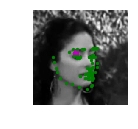

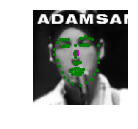

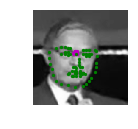

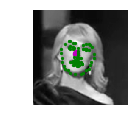

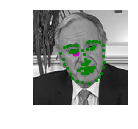

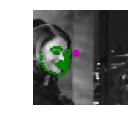

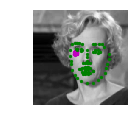

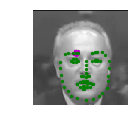

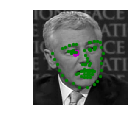

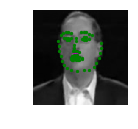

In [12]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [13]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.MSELoss()

optimizer = optim.Adam(net.parameters(), lr = 0.0001)
#different options I tried:
#different hyperparameter: optimizer = optim.Adam(net.parameters(), lr = 0.001)
#different optimizer: optimizer = optim.RMSprop(net.parameters(), lr = 0.01)
#different optimizer: optimizer = optim.SGD(lr=0.1, decay=1e-6, momentum=0.95, nesterov=True)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [14]:
def train_net(n_epochs):
    
    loss_over_time = [] # to track the loss as the network trains

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
            #if batch_i >0:    # print every  batche
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                loss_over_time.append(running_loss/10)
                running_loss = 0.0

    print('Finished Training')
    return loss_over_time


In [15]:
# train your network
n_epochs = 30 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
with active_session():
    training_loss = train_net(n_epochs)

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 0.5826008379459381
Epoch: 1, Batch: 20, Avg. Loss: 0.4232917010784149
Epoch: 1, Batch: 30, Avg. Loss: 0.23680386692285538
Epoch: 1, Batch: 40, Avg. Loss: 0.17334627583622933
Epoch: 1, Batch: 50, Avg. Loss: 0.20563113540410996
Epoch: 1, Batch: 60, Avg. Loss: 0.1638377144932747
Epoch: 1, Batch: 70, Avg. Loss: 0.1770583376288414
Epoch: 1, Batch: 80, Avg. Loss: 0.2322009637951851
Epoch: 1, Batch: 90, Avg. Loss: 0.1598780132830143
Epoch: 1, Batch: 100, Avg. Loss: 0.21810205951333045
Epoch: 1, Batch: 110, Avg. Loss: 0.2581030301749706
Epoch: 1, Batch: 120, Avg. Loss: 0.22335008457303046
Epoch: 1, Batch: 130, Avg. Loss: 0.17081417962908746
Epoch: 1, Batch: 140, Avg. Loss: 0.1613874189555645
Epoch: 1, Batch: 150, Avg. Loss: 0.19689240008592607
Epoch: 1, Batch: 160, Avg. Loss: 0.1763749897480011
Epoch: 1, Batch: 170, Avg. Loss: 0.2811369650065899
Epoch: 1, Batch: 180, Avg. Loss: 0.1975925788283348
Epoch: 1, Batch: 190, Avg. Loss: 0.24055488556623458
Epoch: 1, Bat

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 2, Batch: 10, Avg. Loss: 0.22573124319314958
Epoch: 2, Batch: 20, Avg. Loss: 0.2633423343300819
Epoch: 2, Batch: 30, Avg. Loss: 0.20671259313821794
Epoch: 2, Batch: 40, Avg. Loss: 0.1948852740228176
Epoch: 2, Batch: 50, Avg. Loss: 0.19775840342044831
Epoch: 2, Batch: 60, Avg. Loss: 0.1585799291729927
Epoch: 2, Batch: 70, Avg. Loss: 0.2196967661380768
Epoch: 2, Batch: 80, Avg. Loss: 0.23120169714093208
Epoch: 2, Batch: 90, Avg. Loss: 0.22679003700613976
Epoch: 2, Batch: 100, Avg. Loss: 0.19703168123960496
Epoch: 2, Batch: 110, Avg. Loss: 0.16149481013417244
Epoch: 2, Batch: 120, Avg. Loss: 0.1813664935529232
Epoch: 2, Batch: 130, Avg. Loss: 0.18321149945259094
Epoch: 2, Batch: 140, Avg. Loss: 0.2162925995886326
Epoch: 2, Batch: 150, Avg. Loss: 0.18285336792469026
Epoch: 2, Batch: 160, Avg. Loss: 0.2036893129348755
Epoch: 2, Batch: 170, Avg. Loss: 0.17860298454761506
Epoch: 2, Batch: 180, Avg. Loss: 0.15993354842066765
Epoch: 2, Batch: 190, Avg. Loss: 0.18371040672063826
Epoch: 2,

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 3, Batch: 10, Avg. Loss: 0.19798764511942862
Epoch: 3, Batch: 20, Avg. Loss: 0.20426620543003082
Epoch: 3, Batch: 30, Avg. Loss: 0.19189327359199523
Epoch: 3, Batch: 40, Avg. Loss: 0.20671052783727645
Epoch: 3, Batch: 50, Avg. Loss: 0.24321067929267884
Epoch: 3, Batch: 60, Avg. Loss: 0.15418279245495797
Epoch: 3, Batch: 70, Avg. Loss: 0.18655237928032875
Epoch: 3, Batch: 80, Avg. Loss: 0.16083096265792846
Epoch: 3, Batch: 90, Avg. Loss: 0.18678639382123946
Epoch: 3, Batch: 100, Avg. Loss: 0.15353009477257729
Epoch: 3, Batch: 110, Avg. Loss: 0.1623261071741581
Epoch: 3, Batch: 120, Avg. Loss: 0.16962017193436624
Epoch: 3, Batch: 130, Avg. Loss: 0.18167061358690262
Epoch: 3, Batch: 140, Avg. Loss: 0.15050244182348252
Epoch: 3, Batch: 150, Avg. Loss: 0.15118399858474732
Epoch: 3, Batch: 160, Avg. Loss: 0.2968780793249607
Epoch: 3, Batch: 170, Avg. Loss: 0.18451905697584153
Epoch: 3, Batch: 180, Avg. Loss: 0.1616471879184246
Epoch: 3, Batch: 190, Avg. Loss: 0.1749373897910118
Epoch:

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 4, Batch: 10, Avg. Loss: 0.1616893343627453
Epoch: 4, Batch: 20, Avg. Loss: 0.2750693798065186
Epoch: 4, Batch: 30, Avg. Loss: 0.14471691250801086
Epoch: 4, Batch: 40, Avg. Loss: 0.1331472635269165
Epoch: 4, Batch: 50, Avg. Loss: 0.14963171109557152
Epoch: 4, Batch: 60, Avg. Loss: 0.17907177209854125
Epoch: 4, Batch: 70, Avg. Loss: 0.1461636357009411
Epoch: 4, Batch: 80, Avg. Loss: 0.20388487502932548
Epoch: 4, Batch: 90, Avg. Loss: 0.14517700746655465
Epoch: 4, Batch: 100, Avg. Loss: 0.1446744754910469
Epoch: 4, Batch: 110, Avg. Loss: 0.14160735979676248
Epoch: 4, Batch: 120, Avg. Loss: 0.15492962747812272
Epoch: 4, Batch: 130, Avg. Loss: 0.1790067344903946
Epoch: 4, Batch: 180, Avg. Loss: 0.13365530371665954
Epoch: 4, Batch: 190, Avg. Loss: 0.24059431590139865
Epoch: 4, Batch: 200, Avg. Loss: 0.12608366832137108
Epoch: 4, Batch: 210, Avg. Loss: 0.13070904836058617
Epoch: 4, Batch: 220, Avg. Loss: 0.18490906804800034
Epoch: 4, Batch: 230, Avg. Loss: 0.12954876720905303
Epoch: 4

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 5, Batch: 10, Avg. Loss: 0.12948916032910346
Epoch: 5, Batch: 20, Avg. Loss: 0.17065687701106072
Epoch: 5, Batch: 30, Avg. Loss: 0.12992134876549244
Epoch: 5, Batch: 40, Avg. Loss: 0.19754693545401097
Epoch: 5, Batch: 50, Avg. Loss: 0.1496327690780163
Epoch: 5, Batch: 60, Avg. Loss: 0.2055932365357876
Epoch: 5, Batch: 70, Avg. Loss: 0.17828005477786063
Epoch: 5, Batch: 80, Avg. Loss: 0.14978697821497916
Epoch: 5, Batch: 90, Avg. Loss: 0.1670331686735153
Epoch: 5, Batch: 100, Avg. Loss: 0.17359992265701293
Epoch: 5, Batch: 110, Avg. Loss: 0.14845367074012755
Epoch: 5, Batch: 120, Avg. Loss: 0.1491948075592518
Epoch: 5, Batch: 130, Avg. Loss: 0.15204345509409906
Epoch: 5, Batch: 140, Avg. Loss: 0.12705211862921714
Epoch: 5, Batch: 150, Avg. Loss: 0.12985627725720406
Epoch: 5, Batch: 160, Avg. Loss: 0.14545695036649703
Epoch: 5, Batch: 170, Avg. Loss: 0.1709546312689781
Epoch: 5, Batch: 180, Avg. Loss: 0.14573055878281593
Epoch: 5, Batch: 190, Avg. Loss: 0.13900377601385117
Epoch: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 6, Batch: 10, Avg. Loss: 0.14959821477532387
Epoch: 6, Batch: 20, Avg. Loss: 0.21060456968843938
Epoch: 6, Batch: 30, Avg. Loss: 0.10990760177373886
Epoch: 6, Batch: 40, Avg. Loss: 0.12305370271205902
Epoch: 6, Batch: 50, Avg. Loss: 0.14390100091695784
Epoch: 6, Batch: 60, Avg. Loss: 0.09478128775954246
Epoch: 6, Batch: 70, Avg. Loss: 0.13212447389960288
Epoch: 6, Batch: 80, Avg. Loss: 0.13754609152674674
Epoch: 6, Batch: 90, Avg. Loss: 0.13790837079286575
Epoch: 6, Batch: 100, Avg. Loss: 0.1499454766511917
Epoch: 6, Batch: 110, Avg. Loss: 0.09936597272753715
Epoch: 6, Batch: 120, Avg. Loss: 0.12225012965500355
Epoch: 6, Batch: 130, Avg. Loss: 0.11570270881056785
Epoch: 6, Batch: 140, Avg. Loss: 0.12062047347426415
Epoch: 6, Batch: 150, Avg. Loss: 0.121448715031147
Epoch: 6, Batch: 160, Avg. Loss: 0.1186075121164322
Epoch: 6, Batch: 170, Avg. Loss: 0.1301272004842758
Epoch: 6, Batch: 180, Avg. Loss: 0.13711541518568993
Epoch: 6, Batch: 190, Avg. Loss: 0.12415604293346405
Epoch: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 7, Batch: 10, Avg. Loss: 0.1484627053141594
Epoch: 7, Batch: 20, Avg. Loss: 0.1398840595036745
Epoch: 7, Batch: 30, Avg. Loss: 0.11902953870594501
Epoch: 7, Batch: 40, Avg. Loss: 0.09462766200304032
Epoch: 7, Batch: 50, Avg. Loss: 0.1055731475353241
Epoch: 7, Batch: 60, Avg. Loss: 0.25055003464221953
Epoch: 7, Batch: 70, Avg. Loss: 0.10509346574544906
Epoch: 7, Batch: 80, Avg. Loss: 0.11341677717864514
Epoch: 7, Batch: 90, Avg. Loss: 0.1165685560554266
Epoch: 7, Batch: 100, Avg. Loss: 0.13521624356508255
Epoch: 7, Batch: 110, Avg. Loss: 0.08694267198443413
Epoch: 7, Batch: 120, Avg. Loss: 0.1277087140828371
Epoch: 7, Batch: 130, Avg. Loss: 0.1491713386029005
Epoch: 7, Batch: 140, Avg. Loss: 0.11791960187256337
Epoch: 7, Batch: 150, Avg. Loss: 0.10346394442021847
Epoch: 7, Batch: 160, Avg. Loss: 0.1426515657454729
Epoch: 7, Batch: 170, Avg. Loss: 0.1955809101462364
Epoch: 7, Batch: 180, Avg. Loss: 0.08569730445742607
Epoch: 7, Batch: 190, Avg. Loss: 0.09419399239122868
Epoch: 7, 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 8, Batch: 10, Avg. Loss: 0.10249029360711574
Epoch: 8, Batch: 20, Avg. Loss: 0.12058168426156043
Epoch: 8, Batch: 30, Avg. Loss: 0.12293258756399154
Epoch: 8, Batch: 40, Avg. Loss: 0.1525765798985958
Epoch: 8, Batch: 50, Avg. Loss: 0.3122624926269054
Epoch: 8, Batch: 60, Avg. Loss: 0.07868596725165844
Epoch: 8, Batch: 70, Avg. Loss: 0.10076201520860195
Epoch: 8, Batch: 80, Avg. Loss: 0.10596515387296676
Epoch: 8, Batch: 90, Avg. Loss: 0.0900067962706089
Epoch: 8, Batch: 100, Avg. Loss: 0.1009939081966877
Epoch: 8, Batch: 110, Avg. Loss: 0.098131213337183
Epoch: 8, Batch: 120, Avg. Loss: 0.13232492096722126
Epoch: 8, Batch: 130, Avg. Loss: 0.096739187464118
Epoch: 8, Batch: 170, Avg. Loss: 0.14694756045937538
Epoch: 8, Batch: 180, Avg. Loss: 0.09098471067845822
Epoch: 8, Batch: 190, Avg. Loss: 0.10809379294514657
Epoch: 8, Batch: 200, Avg. Loss: 0.11732664071023464
Epoch: 8, Batch: 210, Avg. Loss: 0.07736431211233138
Epoch: 8, Batch: 220, Avg. Loss: 0.1075925923883915
Epoch: 8, B

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 9, Batch: 10, Avg. Loss: 0.1031315628439188
Epoch: 9, Batch: 20, Avg. Loss: 0.1249353215098381
Epoch: 9, Batch: 30, Avg. Loss: 0.11160242408514023
Epoch: 9, Batch: 40, Avg. Loss: 0.09797553457319737
Epoch: 9, Batch: 50, Avg. Loss: 0.10107116848230362
Epoch: 9, Batch: 60, Avg. Loss: 0.07689001336693764
Epoch: 9, Batch: 70, Avg. Loss: 0.09183825589716435
Epoch: 9, Batch: 80, Avg. Loss: 0.10833029970526695
Epoch: 9, Batch: 90, Avg. Loss: 0.08348394148051738
Epoch: 9, Batch: 100, Avg. Loss: 0.06739412993192673
Epoch: 9, Batch: 110, Avg. Loss: 0.0871455829590559
Epoch: 9, Batch: 120, Avg. Loss: 0.11584684550762177
Epoch: 9, Batch: 130, Avg. Loss: 0.12371371500194073
Epoch: 9, Batch: 140, Avg. Loss: 0.08629033826291561
Epoch: 9, Batch: 150, Avg. Loss: 0.10895203463733197
Epoch: 9, Batch: 160, Avg. Loss: 0.07812593057751656
Epoch: 9, Batch: 170, Avg. Loss: 0.10763582177460193
Epoch: 9, Batch: 180, Avg. Loss: 0.12187827080488205
Epoch: 9, Batch: 190, Avg. Loss: 0.2221457537263632
Epoch:

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 10, Batch: 10, Avg. Loss: 0.10022169463336468
Epoch: 10, Batch: 20, Avg. Loss: 0.11390368081629276
Epoch: 10, Batch: 30, Avg. Loss: 0.07490627728402614
Epoch: 10, Batch: 40, Avg. Loss: 0.09798037260770798
Epoch: 10, Batch: 50, Avg. Loss: 0.10693364776670933
Epoch: 10, Batch: 60, Avg. Loss: 0.06501987352967262
Epoch: 10, Batch: 70, Avg. Loss: 0.09334047175943852
Epoch: 10, Batch: 80, Avg. Loss: 0.09708785563707352
Epoch: 10, Batch: 90, Avg. Loss: 0.18764713667333127
Epoch: 10, Batch: 100, Avg. Loss: 0.12103701978921891
Epoch: 10, Batch: 110, Avg. Loss: 0.2524192236363888
Epoch: 10, Batch: 120, Avg. Loss: 0.07644229270517826
Epoch: 10, Batch: 130, Avg. Loss: 0.08352871276438237
Epoch: 10, Batch: 140, Avg. Loss: 0.05984104685485363
Epoch: 10, Batch: 150, Avg. Loss: 0.10165603719651699
Epoch: 10, Batch: 160, Avg. Loss: 0.11671567969024181
Epoch: 10, Batch: 170, Avg. Loss: 0.09996313229203224
Epoch: 10, Batch: 180, Avg. Loss: 0.09493306055665016
Epoch: 10, Batch: 190, Avg. Loss: 0.06

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 11, Batch: 10, Avg. Loss: 0.1302587378770113
Epoch: 11, Batch: 20, Avg. Loss: 0.09258113447576762
Epoch: 11, Batch: 30, Avg. Loss: 0.11342978850007057
Epoch: 11, Batch: 40, Avg. Loss: 0.13025986924767494
Epoch: 11, Batch: 50, Avg. Loss: 0.08576906844973564
Epoch: 11, Batch: 60, Avg. Loss: 0.1533721812069416
Epoch: 11, Batch: 70, Avg. Loss: 0.08527631014585495
Epoch: 11, Batch: 80, Avg. Loss: 0.06962480843067169
Epoch: 11, Batch: 90, Avg. Loss: 0.08811544105410576
Epoch: 11, Batch: 100, Avg. Loss: 0.07038259729743004
Epoch: 11, Batch: 110, Avg. Loss: 0.08837387412786483
Epoch: 11, Batch: 120, Avg. Loss: 0.08575273901224137
Epoch: 11, Batch: 130, Avg. Loss: 0.0906110905110836
Epoch: 11, Batch: 140, Avg. Loss: 0.06054644137620926
Epoch: 11, Batch: 150, Avg. Loss: 0.07671983018517495
Epoch: 11, Batch: 160, Avg. Loss: 0.08503188528120517
Epoch: 11, Batch: 170, Avg. Loss: 0.10399266798049212
Epoch: 11, Batch: 180, Avg. Loss: 0.07584520801901817
Epoch: 11, Batch: 190, Avg. Loss: 0.0561

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 12, Batch: 10, Avg. Loss: 0.0958256796002388
Epoch: 12, Batch: 20, Avg. Loss: 0.10011859014630317
Epoch: 12, Batch: 30, Avg. Loss: 0.11915747337043285
Epoch: 12, Batch: 40, Avg. Loss: 0.09660360850393772
Epoch: 12, Batch: 50, Avg. Loss: 0.11804138757288456
Epoch: 12, Batch: 60, Avg. Loss: 0.1535672891885042
Epoch: 12, Batch: 70, Avg. Loss: 0.09524875599890947
Epoch: 12, Batch: 80, Avg. Loss: 0.05825252644717693
Epoch: 12, Batch: 90, Avg. Loss: 0.0759542491286993
Epoch: 12, Batch: 100, Avg. Loss: 0.07529901377856732
Epoch: 12, Batch: 110, Avg. Loss: 0.08223715014755725
Epoch: 12, Batch: 120, Avg. Loss: 0.16476760245859623
Epoch: 12, Batch: 130, Avg. Loss: 0.0611454714089632
Epoch: 12, Batch: 140, Avg. Loss: 0.06856696270406246
Epoch: 12, Batch: 150, Avg. Loss: 0.05566483698785305
Epoch: 12, Batch: 160, Avg. Loss: 0.06140376031398773
Epoch: 12, Batch: 170, Avg. Loss: 0.06336199566721916
Epoch: 12, Batch: 180, Avg. Loss: 0.07236766088753939
Epoch: 12, Batch: 190, Avg. Loss: 0.08222

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 13, Batch: 10, Avg. Loss: 0.08571039400994777
Epoch: 13, Batch: 20, Avg. Loss: 0.0665307141840458
Epoch: 13, Batch: 30, Avg. Loss: 0.09719902873039246
Epoch: 13, Batch: 40, Avg. Loss: 0.1264332991093397
Epoch: 13, Batch: 50, Avg. Loss: 0.06783121898770332
Epoch: 13, Batch: 60, Avg. Loss: 0.055344384349882605
Epoch: 13, Batch: 70, Avg. Loss: 0.05681205466389656
Epoch: 13, Batch: 80, Avg. Loss: 0.0690731268376112
Epoch: 13, Batch: 90, Avg. Loss: 0.050670497305691245
Epoch: 13, Batch: 100, Avg. Loss: 0.06475007012486458
Epoch: 13, Batch: 110, Avg. Loss: 0.0663734432309866
Epoch: 13, Batch: 120, Avg. Loss: 0.09470173455774784
Epoch: 13, Batch: 130, Avg. Loss: 0.0952352836728096
Epoch: 13, Batch: 140, Avg. Loss: 0.10323653668165207
Epoch: 13, Batch: 150, Avg. Loss: 0.09855540636926889
Epoch: 13, Batch: 160, Avg. Loss: 0.15489156246185304
Epoch: 13, Batch: 170, Avg. Loss: 0.10371719002723694
Epoch: 13, Batch: 180, Avg. Loss: 0.06267031282186508
Epoch: 13, Batch: 190, Avg. Loss: 0.0619

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 14, Batch: 10, Avg. Loss: 0.055021362379193306
Epoch: 14, Batch: 20, Avg. Loss: 0.068620665371418
Epoch: 14, Batch: 30, Avg. Loss: 0.08375013135373592
Epoch: 14, Batch: 40, Avg. Loss: 0.051100222207605836
Epoch: 14, Batch: 50, Avg. Loss: 0.0582614878192544
Epoch: 14, Batch: 60, Avg. Loss: 0.06475467942655086
Epoch: 14, Batch: 70, Avg. Loss: 0.048265784047544
Epoch: 14, Batch: 80, Avg. Loss: 0.07949060164391994
Epoch: 14, Batch: 90, Avg. Loss: 0.054801985435187814
Epoch: 14, Batch: 100, Avg. Loss: 0.07323239501565695
Epoch: 14, Batch: 110, Avg. Loss: 0.07602724358439446
Epoch: 14, Batch: 120, Avg. Loss: 0.12257254123687744
Epoch: 14, Batch: 130, Avg. Loss: 0.06889199856668711
Epoch: 14, Batch: 140, Avg. Loss: 0.05282367095351219
Epoch: 14, Batch: 150, Avg. Loss: 0.17975870482623577
Epoch: 14, Batch: 160, Avg. Loss: 0.0962399873882532
Epoch: 14, Batch: 170, Avg. Loss: 0.06369647905230522
Epoch: 14, Batch: 180, Avg. Loss: 0.0518964683637023
Epoch: 14, Batch: 190, Avg. Loss: 0.10270

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 15, Batch: 10, Avg. Loss: 0.05262845456600189
Epoch: 15, Batch: 20, Avg. Loss: 0.06190108880400658
Epoch: 15, Batch: 30, Avg. Loss: 0.12315865121781826
Epoch: 15, Batch: 40, Avg. Loss: 0.11478461548686028
Epoch: 15, Batch: 50, Avg. Loss: 0.06887818276882171
Epoch: 15, Batch: 60, Avg. Loss: 0.11142039448022842
Epoch: 15, Batch: 70, Avg. Loss: 0.05173397772014141
Epoch: 15, Batch: 80, Avg. Loss: 0.05849421545863152
Epoch: 15, Batch: 90, Avg. Loss: 0.06845537088811397
Epoch: 15, Batch: 100, Avg. Loss: 0.05955121219158173
Epoch: 15, Batch: 110, Avg. Loss: 0.05519374459981918
Epoch: 15, Batch: 120, Avg. Loss: 0.06276455260813237
Epoch: 15, Batch: 130, Avg. Loss: 0.04776139352470636
Epoch: 15, Batch: 140, Avg. Loss: 0.04907426200807095
Epoch: 15, Batch: 150, Avg. Loss: 0.07731461897492409
Epoch: 15, Batch: 160, Avg. Loss: 0.05245680920779705
Epoch: 15, Batch: 170, Avg. Loss: 0.07685052044689655
Epoch: 15, Batch: 180, Avg. Loss: 0.055772670172154905
Epoch: 15, Batch: 190, Avg. Loss: 0.

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 16, Batch: 10, Avg. Loss: 0.04874041080474854
Epoch: 16, Batch: 20, Avg. Loss: 0.050153433345258236
Epoch: 16, Batch: 30, Avg. Loss: 0.05214698631316424
Epoch: 16, Batch: 40, Avg. Loss: 0.08089411985129118
Epoch: 16, Batch: 50, Avg. Loss: 0.06125302892178297
Epoch: 16, Batch: 60, Avg. Loss: 0.05231060013175011
Epoch: 16, Batch: 70, Avg. Loss: 0.05738722831010819
Epoch: 16, Batch: 80, Avg. Loss: 0.07481905668973923
Epoch: 16, Batch: 90, Avg. Loss: 0.04914049059152603
Epoch: 16, Batch: 100, Avg. Loss: 0.06534964647144079
Epoch: 16, Batch: 110, Avg. Loss: 0.07717961985617876
Epoch: 16, Batch: 120, Avg. Loss: 0.06862870305776596
Epoch: 16, Batch: 130, Avg. Loss: 0.04791962001472712
Epoch: 16, Batch: 140, Avg. Loss: 0.053657783195376396
Epoch: 16, Batch: 150, Avg. Loss: 0.10702573899179697
Epoch: 16, Batch: 160, Avg. Loss: 0.06710260845720768
Epoch: 16, Batch: 170, Avg. Loss: 0.06704172007739544
Epoch: 16, Batch: 180, Avg. Loss: 0.05599135830998421
Epoch: 16, Batch: 190, Avg. Loss: 0

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 17, Batch: 10, Avg. Loss: 0.08128727357834578
Epoch: 17, Batch: 20, Avg. Loss: 0.09267887733876705
Epoch: 17, Batch: 30, Avg. Loss: 0.045714755356311795
Epoch: 17, Batch: 40, Avg. Loss: 0.06540572196245194
Epoch: 17, Batch: 50, Avg. Loss: 0.05019290968775749
Epoch: 17, Batch: 60, Avg. Loss: 0.07363932374864816
Epoch: 17, Batch: 70, Avg. Loss: 0.05720862802118063
Epoch: 17, Batch: 80, Avg. Loss: 0.13807484097778797
Epoch: 17, Batch: 90, Avg. Loss: 0.08010964337736368
Epoch: 17, Batch: 100, Avg. Loss: 0.10502759497612715
Epoch: 17, Batch: 110, Avg. Loss: 0.06746658384799957
Epoch: 17, Batch: 120, Avg. Loss: 0.0655812406912446
Epoch: 17, Batch: 130, Avg. Loss: 0.06116995960474014
Epoch: 17, Batch: 140, Avg. Loss: 0.06643610280007124
Epoch: 17, Batch: 150, Avg. Loss: 0.07672496661543846
Epoch: 17, Batch: 160, Avg. Loss: 0.06147533450275659
Epoch: 17, Batch: 170, Avg. Loss: 0.05321238413453102
Epoch: 17, Batch: 180, Avg. Loss: 0.10176733825355769
Epoch: 17, Batch: 190, Avg. Loss: 0.0

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 18, Batch: 10, Avg. Loss: 0.08757384475320577
Epoch: 18, Batch: 20, Avg. Loss: 0.08790797255933284
Epoch: 18, Batch: 30, Avg. Loss: 0.10605921149253845
Epoch: 18, Batch: 40, Avg. Loss: 0.03982134200632572
Epoch: 18, Batch: 50, Avg. Loss: 0.06811725702136755
Epoch: 18, Batch: 60, Avg. Loss: 0.05378461107611656
Epoch: 18, Batch: 70, Avg. Loss: 0.060857022926211354
Epoch: 18, Batch: 80, Avg. Loss: 0.06042080093175173
Epoch: 18, Batch: 90, Avg. Loss: 0.059749802201986314
Epoch: 18, Batch: 100, Avg. Loss: 0.05876841191202402
Epoch: 18, Batch: 110, Avg. Loss: 0.0472956283017993
Epoch: 18, Batch: 120, Avg. Loss: 0.06192387416958809
Epoch: 18, Batch: 130, Avg. Loss: 0.07762523740530014
Epoch: 18, Batch: 140, Avg. Loss: 0.06483671180903912
Epoch: 18, Batch: 150, Avg. Loss: 0.06340069025754928
Epoch: 18, Batch: 160, Avg. Loss: 0.08363280482590199
Epoch: 18, Batch: 170, Avg. Loss: 0.09150016866624355
Epoch: 18, Batch: 180, Avg. Loss: 0.05164475739002228
Epoch: 18, Batch: 190, Avg. Loss: 0.

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 19, Batch: 10, Avg. Loss: 0.053287883289158344
Epoch: 19, Batch: 20, Avg. Loss: 0.0851781964302063
Epoch: 19, Batch: 30, Avg. Loss: 0.1163450013846159
Epoch: 19, Batch: 40, Avg. Loss: 0.08614298850297927
Epoch: 19, Batch: 50, Avg. Loss: 0.07333038412034512
Epoch: 19, Batch: 60, Avg. Loss: 0.03807239681482315
Epoch: 19, Batch: 70, Avg. Loss: 0.07060824874788522
Epoch: 19, Batch: 80, Avg. Loss: 0.0780545735731721
Epoch: 19, Batch: 90, Avg. Loss: 0.12534662708640099
Epoch: 19, Batch: 100, Avg. Loss: 0.07337493449449539
Epoch: 19, Batch: 110, Avg. Loss: 0.07169056460261344
Epoch: 19, Batch: 120, Avg. Loss: 0.04361315276473761
Epoch: 19, Batch: 130, Avg. Loss: 0.0457792092114687
Epoch: 19, Batch: 140, Avg. Loss: 0.05606958996504545
Epoch: 19, Batch: 150, Avg. Loss: 0.05109638720750809
Epoch: 19, Batch: 160, Avg. Loss: 0.059069111570715906
Epoch: 19, Batch: 170, Avg. Loss: 0.054273816756904125
Epoch: 19, Batch: 180, Avg. Loss: 0.05885436218231917
Epoch: 19, Batch: 190, Avg. Loss: 0.07

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 20, Batch: 10, Avg. Loss: 0.041567859798669816
Epoch: 20, Batch: 20, Avg. Loss: 0.14833785630762578
Epoch: 20, Batch: 30, Avg. Loss: 0.062102267146110536
Epoch: 20, Batch: 40, Avg. Loss: 0.06445848532021045
Epoch: 20, Batch: 50, Avg. Loss: 0.05285176523029804
Epoch: 20, Batch: 60, Avg. Loss: 0.04178845603018999
Epoch: 20, Batch: 70, Avg. Loss: 0.05477156527340412
Epoch: 20, Batch: 80, Avg. Loss: 0.13613581098616123
Epoch: 20, Batch: 120, Avg. Loss: 0.06692260503768921
Epoch: 20, Batch: 130, Avg. Loss: 0.0965788809582591
Epoch: 20, Batch: 140, Avg. Loss: 0.0385901452973485
Epoch: 20, Batch: 150, Avg. Loss: 0.053145249374210835
Epoch: 20, Batch: 160, Avg. Loss: 0.0589060265570879
Epoch: 20, Batch: 170, Avg. Loss: 0.06268093772232533
Epoch: 20, Batch: 180, Avg. Loss: 0.0682955902069807
Epoch: 20, Batch: 190, Avg. Loss: 0.04699098356068134
Epoch: 20, Batch: 200, Avg. Loss: 0.07541019506752492
Epoch: 20, Batch: 210, Avg. Loss: 0.06513202488422394
Epoch: 20, Batch: 220, Avg. Loss: 0.0

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 21, Batch: 10, Avg. Loss: 0.0455272413790226
Epoch: 21, Batch: 20, Avg. Loss: 0.05803683213889599
Epoch: 21, Batch: 30, Avg. Loss: 0.05511737540364266
Epoch: 21, Batch: 40, Avg. Loss: 0.052274078130722046
Epoch: 21, Batch: 50, Avg. Loss: 0.0495499262586236
Epoch: 21, Batch: 60, Avg. Loss: 0.06185783557593823
Epoch: 21, Batch: 70, Avg. Loss: 0.050707035884261134
Epoch: 21, Batch: 80, Avg. Loss: 0.06648220792412758
Epoch: 21, Batch: 90, Avg. Loss: 0.04271964766085148
Epoch: 21, Batch: 100, Avg. Loss: 0.0507182065397501
Epoch: 21, Batch: 110, Avg. Loss: 0.047698724642395975
Epoch: 21, Batch: 120, Avg. Loss: 0.04359562154859305
Epoch: 21, Batch: 130, Avg. Loss: 0.051743412390351295
Epoch: 21, Batch: 140, Avg. Loss: 0.05827038865536451
Epoch: 21, Batch: 150, Avg. Loss: 0.03427710924297571
Epoch: 21, Batch: 160, Avg. Loss: 0.04919208027422428
Epoch: 21, Batch: 170, Avg. Loss: 0.19537631161510943
Epoch: 21, Batch: 180, Avg. Loss: 0.05826147980988026
Epoch: 21, Batch: 190, Avg. Loss: 0.

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 22, Batch: 10, Avg. Loss: 0.055789423361420634
Epoch: 22, Batch: 20, Avg. Loss: 0.08090094178915024
Epoch: 22, Batch: 30, Avg. Loss: 0.07000819407403469
Epoch: 22, Batch: 40, Avg. Loss: 0.13467663377523423
Epoch: 22, Batch: 50, Avg. Loss: 0.03682301864027977
Epoch: 22, Batch: 60, Avg. Loss: 0.03589731641113758
Epoch: 22, Batch: 70, Avg. Loss: 0.06020542569458485
Epoch: 22, Batch: 80, Avg. Loss: 0.036926277354359625
Epoch: 22, Batch: 90, Avg. Loss: 0.06179547049105168
Epoch: 22, Batch: 100, Avg. Loss: 0.03947824258357287
Epoch: 22, Batch: 110, Avg. Loss: 0.05189576894044876
Epoch: 22, Batch: 120, Avg. Loss: 0.04561696220189333
Epoch: 22, Batch: 130, Avg. Loss: 0.060479416884481906
Epoch: 22, Batch: 140, Avg. Loss: 0.04188464153558016
Epoch: 22, Batch: 150, Avg. Loss: 0.054498101212084295
Epoch: 22, Batch: 160, Avg. Loss: 0.05248429458588362
Epoch: 22, Batch: 170, Avg. Loss: 0.048488167487084864
Epoch: 22, Batch: 180, Avg. Loss: 0.047491608560085295
Epoch: 22, Batch: 190, Avg. Los

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 23, Batch: 10, Avg. Loss: 0.05801778472959995
Epoch: 23, Batch: 20, Avg. Loss: 0.0411892406642437
Epoch: 23, Batch: 30, Avg. Loss: 0.03664643764495849
Epoch: 23, Batch: 40, Avg. Loss: 0.036148625798523425
Epoch: 23, Batch: 50, Avg. Loss: 0.0438371604308486
Epoch: 23, Batch: 60, Avg. Loss: 0.05946917794644833
Epoch: 23, Batch: 70, Avg. Loss: 0.0777665762230754
Epoch: 23, Batch: 80, Avg. Loss: 0.0411650788038969
Epoch: 23, Batch: 90, Avg. Loss: 0.047793655283749105
Epoch: 23, Batch: 100, Avg. Loss: 0.04029406290501356
Epoch: 23, Batch: 110, Avg. Loss: 0.044026078470051286
Epoch: 23, Batch: 120, Avg. Loss: 0.03404648676514625
Epoch: 23, Batch: 130, Avg. Loss: 0.04909654948860407
Epoch: 23, Batch: 140, Avg. Loss: 0.031126945558935405
Epoch: 23, Batch: 150, Avg. Loss: 0.05959018114954233
Epoch: 23, Batch: 160, Avg. Loss: 0.053631778433918954
Epoch: 23, Batch: 170, Avg. Loss: 0.04406114462763071
Epoch: 23, Batch: 180, Avg. Loss: 0.05300038363784552
Epoch: 23, Batch: 190, Avg. Loss: 0.

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 24, Batch: 10, Avg. Loss: 0.05473573449999094
Epoch: 24, Batch: 20, Avg. Loss: 0.07272922527045012
Epoch: 24, Batch: 30, Avg. Loss: 0.043738001771271226
Epoch: 24, Batch: 40, Avg. Loss: 0.07040457166731358
Epoch: 24, Batch: 50, Avg. Loss: 0.055102183297276494
Epoch: 24, Batch: 60, Avg. Loss: 0.061562180146574975
Epoch: 24, Batch: 70, Avg. Loss: 0.051895387656986716
Epoch: 24, Batch: 80, Avg. Loss: 0.04010045770555735
Epoch: 24, Batch: 90, Avg. Loss: 0.05619561690837145
Epoch: 24, Batch: 100, Avg. Loss: 0.07538660690188408
Epoch: 24, Batch: 110, Avg. Loss: 0.09971165303140879
Epoch: 24, Batch: 120, Avg. Loss: 0.036642398498952386
Epoch: 24, Batch: 130, Avg. Loss: 0.05193341821432114
Epoch: 24, Batch: 140, Avg. Loss: 0.0484310882166028
Epoch: 24, Batch: 150, Avg. Loss: 0.04436948802322149
Epoch: 24, Batch: 160, Avg. Loss: 0.03676043935120106
Epoch: 24, Batch: 170, Avg. Loss: 0.07009650114923716
Epoch: 24, Batch: 180, Avg. Loss: 0.05175336394459009
Epoch: 24, Batch: 190, Avg. Loss:

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 25, Batch: 10, Avg. Loss: 0.042255124822258947
Epoch: 25, Batch: 20, Avg. Loss: 0.07461210712790489
Epoch: 25, Batch: 30, Avg. Loss: 0.11886623036116362
Epoch: 25, Batch: 40, Avg. Loss: 0.0479857450351119
Epoch: 25, Batch: 50, Avg. Loss: 0.034058013930916786
Epoch: 25, Batch: 60, Avg. Loss: 0.05599601436406374
Epoch: 25, Batch: 70, Avg. Loss: 0.03674803003668785
Epoch: 25, Batch: 80, Avg. Loss: 0.050855183973908424
Epoch: 25, Batch: 90, Avg. Loss: 0.05886884815990925
Epoch: 25, Batch: 100, Avg. Loss: 0.05315481144934893
Epoch: 25, Batch: 110, Avg. Loss: 0.057676440291106704
Epoch: 25, Batch: 120, Avg. Loss: 0.060489445179700854
Epoch: 25, Batch: 130, Avg. Loss: 0.040956514328718184
Epoch: 25, Batch: 140, Avg. Loss: 0.03282670099288225
Epoch: 25, Batch: 150, Avg. Loss: 0.08122168108820915
Epoch: 25, Batch: 160, Avg. Loss: 0.05442197788506746
Epoch: 25, Batch: 170, Avg. Loss: 0.04149699043482542
Epoch: 25, Batch: 180, Avg. Loss: 0.07847933359444141
Epoch: 25, Batch: 190, Avg. Loss

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 26, Batch: 10, Avg. Loss: 0.0529640669003129
Epoch: 26, Batch: 20, Avg. Loss: 0.04729359075427055
Epoch: 26, Batch: 30, Avg. Loss: 0.039019848220050335
Epoch: 26, Batch: 40, Avg. Loss: 0.051299449615180494
Epoch: 26, Batch: 50, Avg. Loss: 0.049815553985536096
Epoch: 26, Batch: 60, Avg. Loss: 0.051685122214257716
Epoch: 26, Batch: 70, Avg. Loss: 0.03407432697713375
Epoch: 26, Batch: 80, Avg. Loss: 0.05111707635223865
Epoch: 26, Batch: 130, Avg. Loss: 0.05110373422503471
Epoch: 26, Batch: 140, Avg. Loss: 0.045935452543199064
Epoch: 26, Batch: 150, Avg. Loss: 0.16121062356978655
Epoch: 26, Batch: 160, Avg. Loss: 0.054051644168794155
Epoch: 26, Batch: 170, Avg. Loss: 0.04611956551671028
Epoch: 26, Batch: 180, Avg. Loss: 0.04919709637761116
Epoch: 26, Batch: 190, Avg. Loss: 0.03918307777494192
Epoch: 26, Batch: 200, Avg. Loss: 0.050970063731074336
Epoch: 26, Batch: 210, Avg. Loss: 0.0635041031986475
Epoch: 26, Batch: 220, Avg. Loss: 0.07227250337600707
Epoch: 26, Batch: 230, Avg. Los

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 27, Batch: 10, Avg. Loss: 0.08486103974282741
Epoch: 27, Batch: 20, Avg. Loss: 0.03785115424543619
Epoch: 27, Batch: 30, Avg. Loss: 0.03730976125225425
Epoch: 27, Batch: 40, Avg. Loss: 0.047852334938943385
Epoch: 27, Batch: 50, Avg. Loss: 0.030074878968298434
Epoch: 27, Batch: 60, Avg. Loss: 0.02998019438236952
Epoch: 27, Batch: 70, Avg. Loss: 0.04180501531809568
Epoch: 27, Batch: 80, Avg. Loss: 0.03740872703492641
Epoch: 27, Batch: 90, Avg. Loss: 0.05602260567247867
Epoch: 27, Batch: 100, Avg. Loss: 0.07257956247776746
Epoch: 27, Batch: 110, Avg. Loss: 0.04801433328539133
Epoch: 27, Batch: 120, Avg. Loss: 0.057775982096791266
Epoch: 27, Batch: 130, Avg. Loss: 0.04399100709706545
Epoch: 27, Batch: 140, Avg. Loss: 0.03687594626098871
Epoch: 27, Batch: 150, Avg. Loss: 0.040347712114453316
Epoch: 27, Batch: 160, Avg. Loss: 0.04757344536483288
Epoch: 27, Batch: 170, Avg. Loss: 0.03299871850758791
Epoch: 27, Batch: 180, Avg. Loss: 0.06164974542334676
Epoch: 27, Batch: 190, Avg. Loss:

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 28, Batch: 10, Avg. Loss: 0.03789332378655672
Epoch: 28, Batch: 20, Avg. Loss: 0.07751792259514331
Epoch: 28, Batch: 30, Avg. Loss: 0.05833041053265333
Epoch: 28, Batch: 40, Avg. Loss: 0.039852218516170976
Epoch: 28, Batch: 50, Avg. Loss: 0.0658914566040039
Epoch: 28, Batch: 60, Avg. Loss: 0.042580468021333216
Epoch: 28, Batch: 70, Avg. Loss: 0.04841744862496853
Epoch: 28, Batch: 80, Avg. Loss: 0.07778681190684437
Epoch: 28, Batch: 90, Avg. Loss: 0.03073514923453331
Epoch: 28, Batch: 100, Avg. Loss: 0.03830255027860403
Epoch: 28, Batch: 110, Avg. Loss: 0.047434511967003344
Epoch: 28, Batch: 120, Avg. Loss: 0.0443509204313159
Epoch: 28, Batch: 130, Avg. Loss: 0.0400257783010602
Epoch: 28, Batch: 140, Avg. Loss: 0.02723229434341192
Epoch: 28, Batch: 150, Avg. Loss: 0.04942100364714861
Epoch: 28, Batch: 160, Avg. Loss: 0.033230130933225153
Epoch: 28, Batch: 170, Avg. Loss: 0.04295570757240057
Epoch: 28, Batch: 180, Avg. Loss: 0.038509464077651503
Epoch: 28, Batch: 190, Avg. Loss: 0

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 29, Batch: 10, Avg. Loss: 0.04189511071890593
Epoch: 29, Batch: 20, Avg. Loss: 0.03749572206288576
Epoch: 29, Batch: 30, Avg. Loss: 0.040011112205684186
Epoch: 29, Batch: 40, Avg. Loss: 0.03960994053632021
Epoch: 29, Batch: 50, Avg. Loss: 0.03478172272443771
Epoch: 29, Batch: 60, Avg. Loss: 0.056773044914007184
Epoch: 29, Batch: 70, Avg. Loss: 0.03691826835274696
Epoch: 29, Batch: 80, Avg. Loss: 0.06206469889730215
Epoch: 29, Batch: 90, Avg. Loss: 0.03949696738272905
Epoch: 29, Batch: 100, Avg. Loss: 0.050721071660518646
Epoch: 29, Batch: 110, Avg. Loss: 0.041137883067131044
Epoch: 29, Batch: 120, Avg. Loss: 0.03147741612046957
Epoch: 29, Batch: 130, Avg. Loss: 0.03476030826568603
Epoch: 29, Batch: 140, Avg. Loss: 0.04830720815807581
Epoch: 29, Batch: 150, Avg. Loss: 0.03278665402904153
Epoch: 29, Batch: 160, Avg. Loss: 0.03139880709350109
Epoch: 29, Batch: 170, Avg. Loss: 0.03961171731352806
Epoch: 29, Batch: 180, Avg. Loss: 0.13605243917554616
Epoch: 29, Batch: 190, Avg. Loss:

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [23]:
# visualize the loss as the network trained
plt.plot(loss_over_time)
plt.xlabel('10\'s of batches')
plt.ylabel('loss')
plt.ylim(0, 1) # consistent scale
plt.show()

NameError: name 'loss_over_time' is not defined

In [17]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
## print(test_outputs) # added
print(gt_pts.size())
## print(gt_pts) # added

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


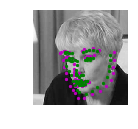

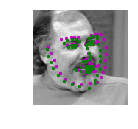

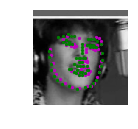

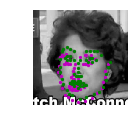

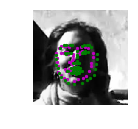

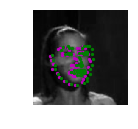

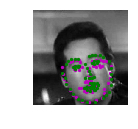

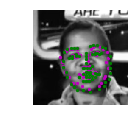

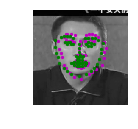

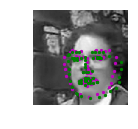

In [18]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)



Once you've found a good model (or two), save your model so you can load it and use it later!

Save your models but please **delete any checkpoints and saved models before you submit your project** otherwise your workspace may be too large to submit.

In [25]:
## ORIG save version
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_noFour_30e_10b.pt'

# 'keypoints_model_no4.pt' -->model_n03

#after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

#uncomment to load model
state_dict = torch.load(model_dir+model_name)
net.load_state_dict(state_dict)

#print(net)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: I started with only two convolutional layers but increased the number of convolutional layers to five. To prevent overfitting the data, I added maxPooling after each convolutional layer and dropout layer with 20% dropout rate after the first four conv. layers.I opted for MSEloss which measure the mean squared error (squared L2 norm) between
    each element in the input and target because it is a good measure of the Euclidean distance between points. If the MSE would be 0 it would mean that the model was trained perfecly with 0 error.
    
  I opted for Adam optimisation method as it was mentioned in the referenced paper. I set the hyperparameter learning rate (lr) to 0.0001: it is 10 times slower learning rate than default of 0.001; and the others to default values. 

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: I started with only two convolutional layers but increased the number of convolutional layers to five. To prevent overfitting the data, I added maxPooling after each convolutional layer and dropout layer with 20% dropout rate after the first four conv. layers.

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: I started testing my architecture with small number of epochs e.g. 1 or 3 and the default batch size of 10. After finding a good architecture I run the model in 30 epochs and batch size 10. As the results were satisfactory, I run the optimization in 15 epochs and using the batch size of 20.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[-0.0258509   0.06700417  0.01277649 -0.0963516   0.07654484]
 [ 0.17662568 -0.19128171 -0.00800318 -0.10954293 -0.06563482]
 [ 0.11389145 -0.14180748 -0.08777412  0.08114538 -0.0546416 ]
 [ 0.19723789  0.1725834  -0.10504156  0.12614244 -0.15346079]
 [ 0.10546603  0.1318358  -0.0278697   0.11031301  0.20517407]]
(5, 5)


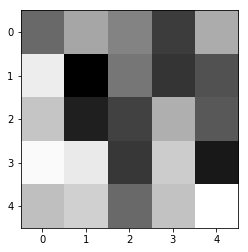

In [20]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

(224, 224)


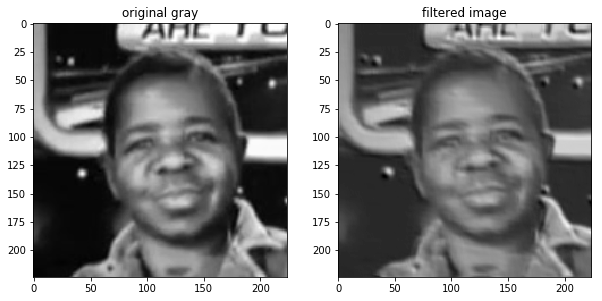

In [28]:
##TODO: load in and display any image from the transformed test dataset
#import matplotlib.pyplot as plt
#import matplotlib.image as mpimg

import cv2
#import numpy as np

%matplotlib inline
imgNo=7
myImage = np.squeeze(test_images[imgNo].data)
myImage = myImage.numpy()  
print(myImage.shape)
## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
myFilter=w[filter_index][0]
filtered_image = cv2.filter2D(myImage, -1, myFilter)

#plt.imshow(filtered_image, cmap='gray')


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('original gray')
ax1.imshow(myImage, cmap='gray')

ax2.set_title('filtered image')
ax2.imshow(filtered_image, cmap='gray')


### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: By comparing how the original image and the filtered image look: the filtered image is less sharp with less sharp edges, I conclude that the filter has the blurring (smoothing) effect.

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!